In [1]:
from googlefinance import getQuotes
from yahoo_finance_api2 import share
import json
import datetime
import pandas as pd
# import pandas_datareader as web
# from pandas_datareader import data, wb

import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yfin
import matplotlib.pyplot as plt

from commons import read_xls, get_stock_data, NSE_BSE, BSE_NSE, save_csv, get_holding_quantities
from consts import OUT_DIR

In [2]:
### Query Period and timeframe
START = dt.datetime(2015, 1, 1) #dt.datetime(2020, 1, 1)
END = dt.datetime.today()
INTERVAL = '1wk' #'1d'
QTYS = get_holding_quantities()
PNG_FOLDER_NAME ='fundamental_data/'


In [3]:
def get_first_non_nan(df):
    df1 = df.fillna('NULL')
    d = dict()
    for s in NSE_BSE.keys():
        for v in df1[s].to_list():
            if v != 'NULL':
                break

        d[s] = v
        
    return pd.Series(d)

[*********************100%%**********************]  25 of 25 completed


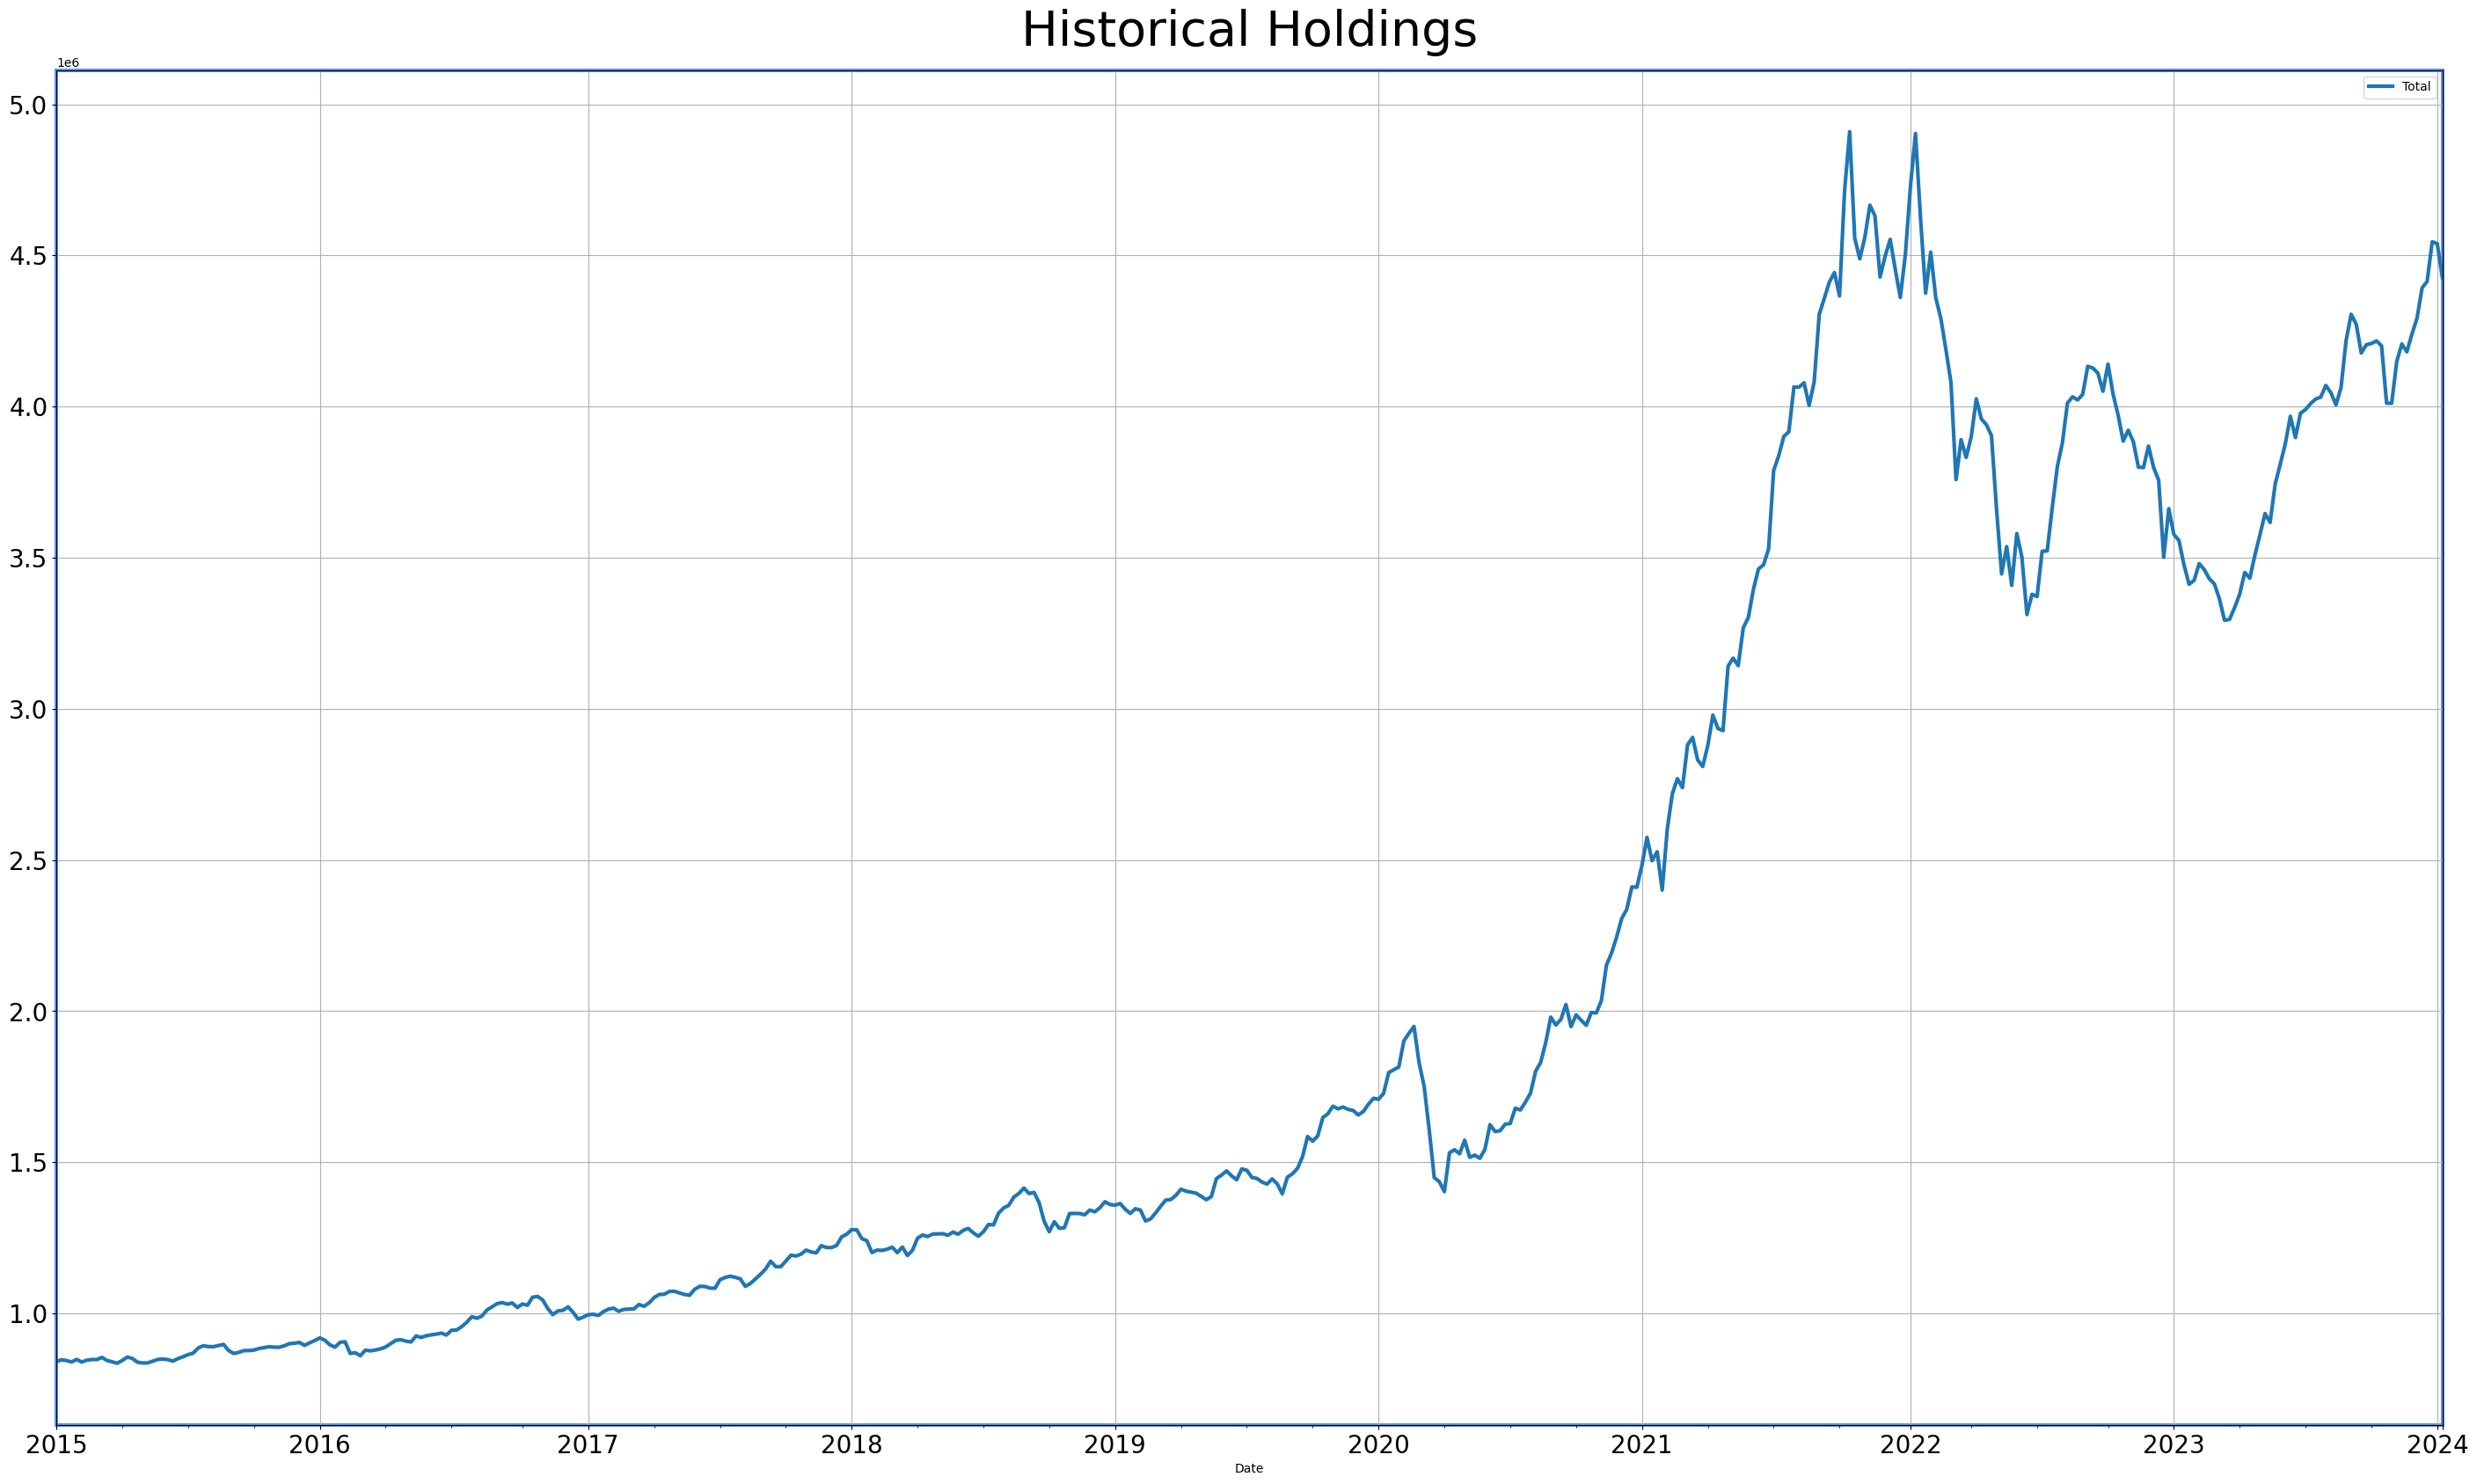

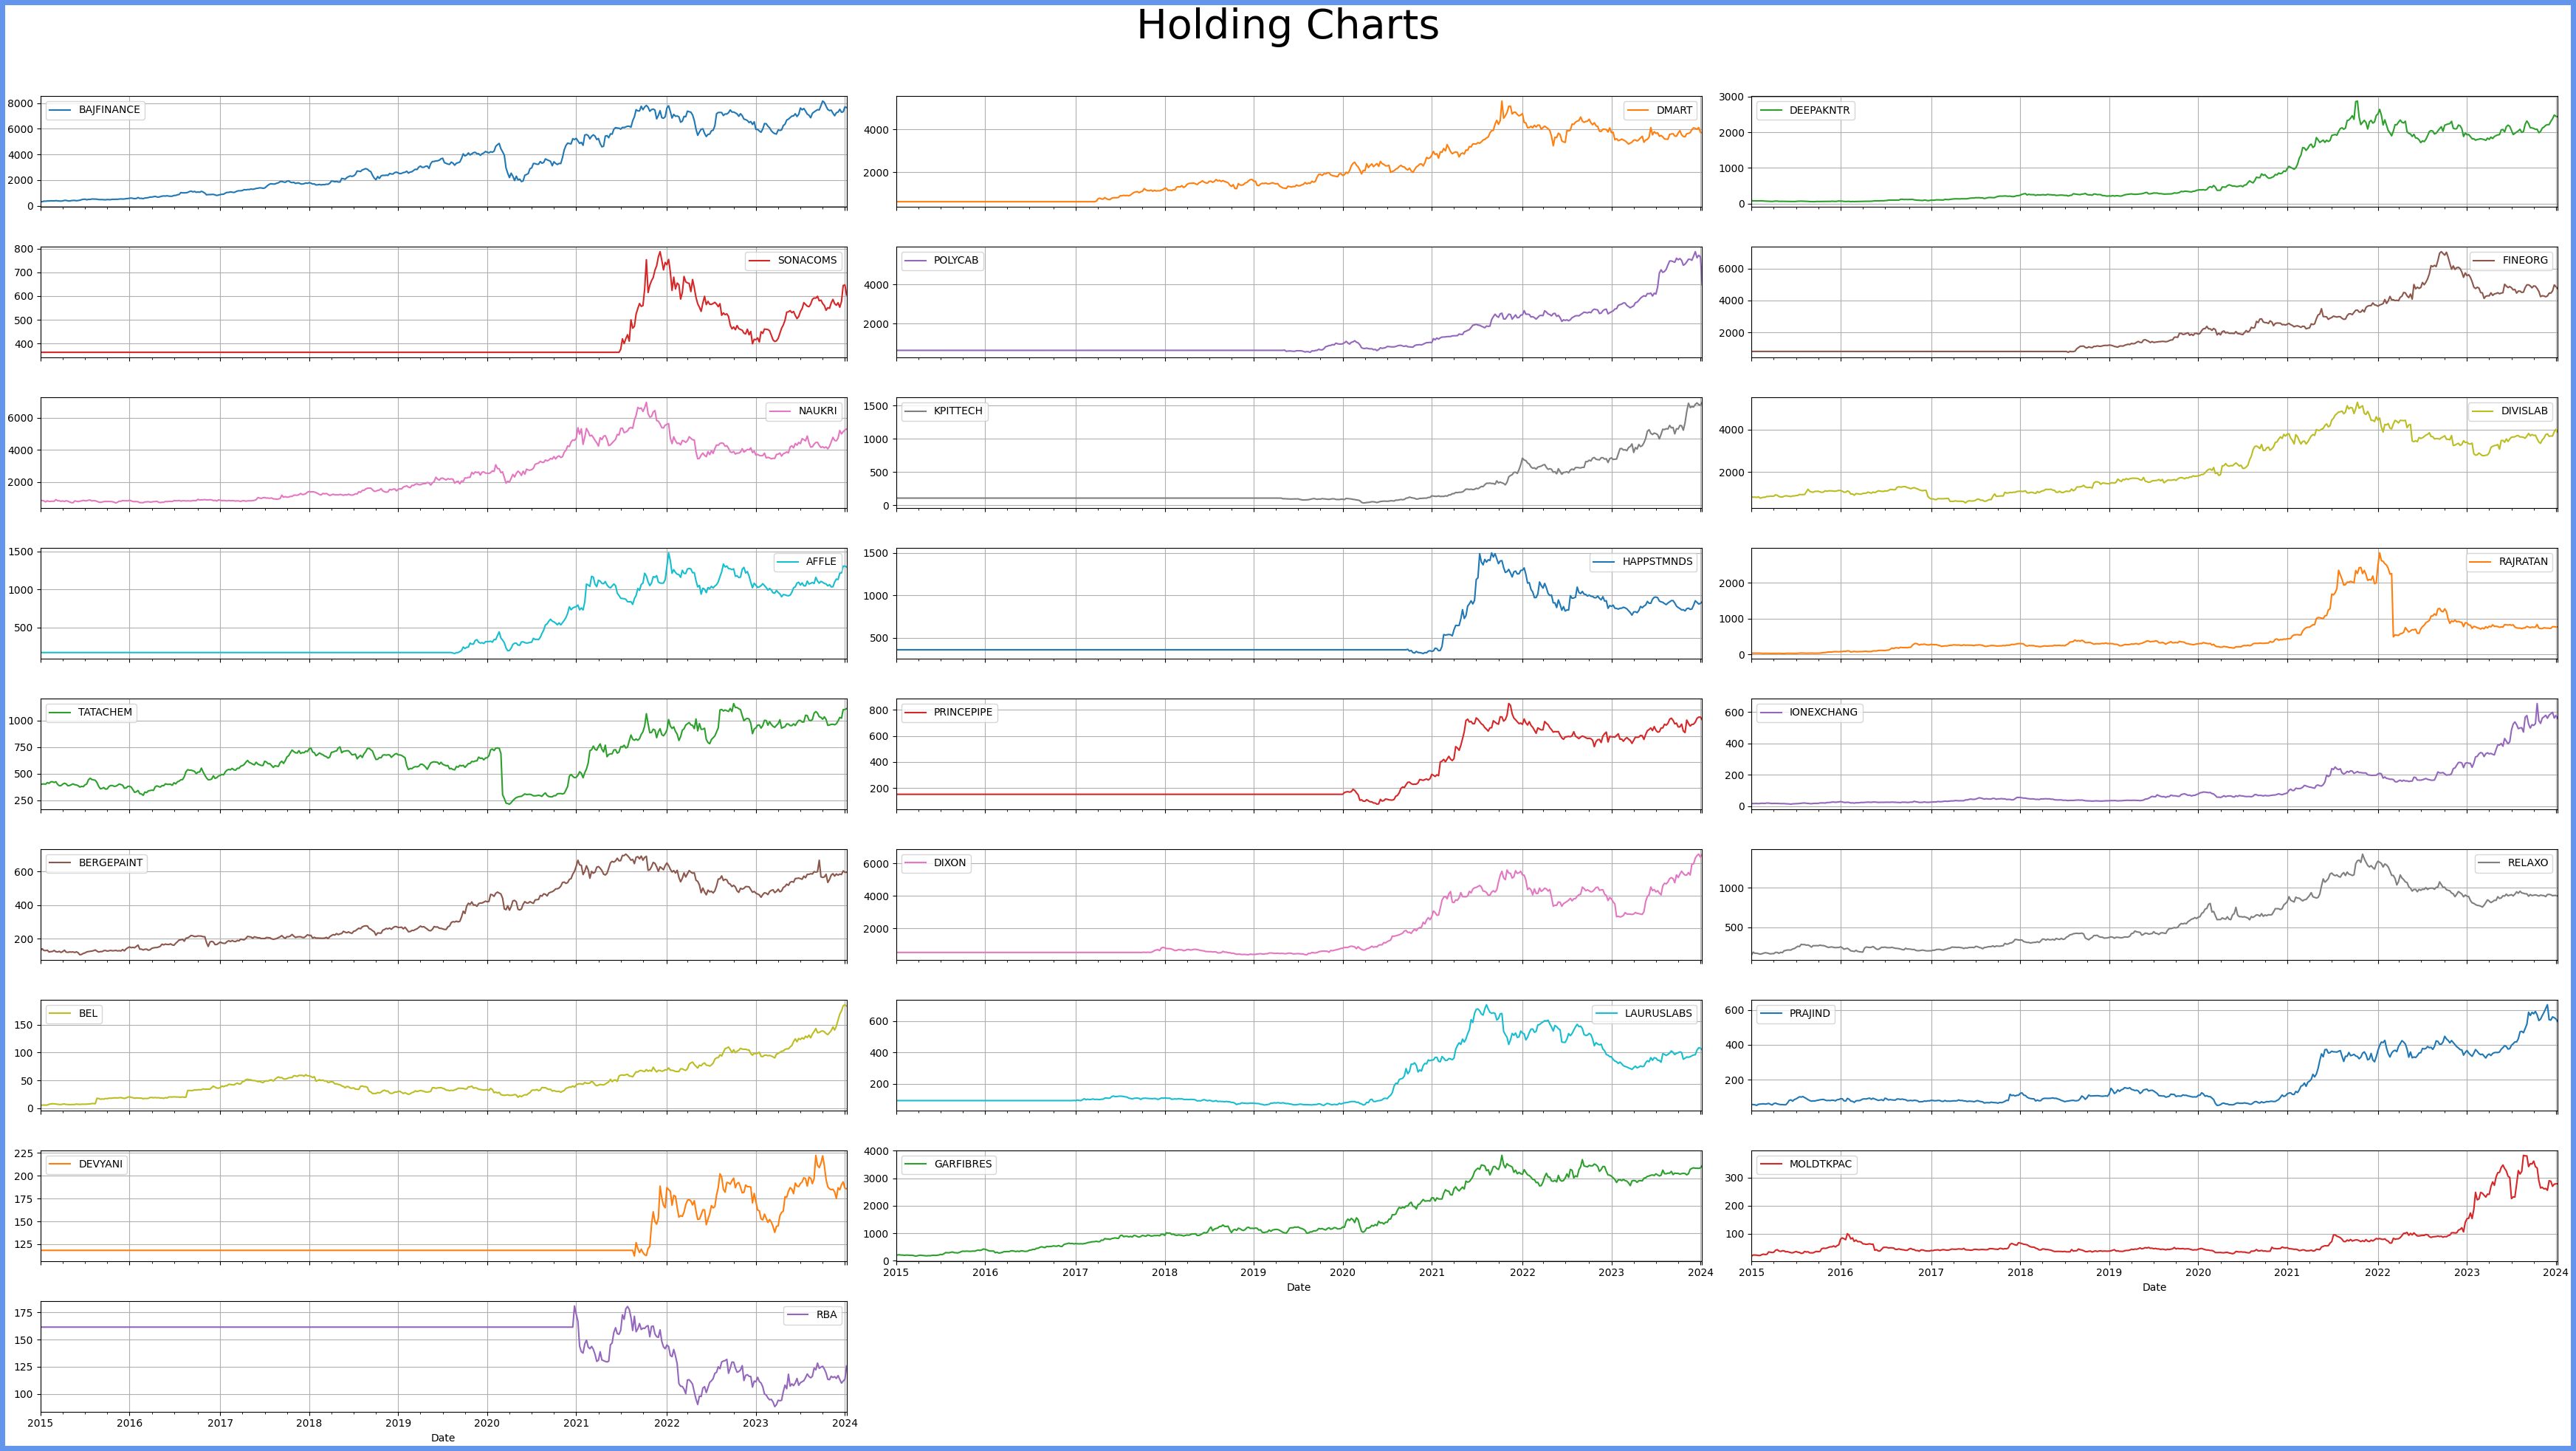

In [4]:
stocks = list(NSE_BSE.values())
yfin.pdr_override()

df = pdr.get_data_yahoo(stocks, start=START, end=END, interval=INTERVAL)
if INTERVAL == '1wk':
    df = df.asfreq('W-FRI', method='pad')
df = df['Adj Close']
df = df.rename(columns=BSE_NSE)


# df.mean()
# df = df.fillna(df.mean())
# https://stackoverflow.com/questions/42137529/pandas-find-first-non-null-value-in-column
# print(df.loc[~df.isnull().sum(1).astype(bool)].iloc[0]) ### Buggy... HAPPSTMNDS wrong

# Fill first listed value previously for new stocks
df1 = df.fillna(get_first_non_nan(df))

for k in NSE_BSE.keys():
    df1[f'{k}_QTY'] = QTYS[k]

# print(df)

def myfunc(k):
#     print(f"{type(k)}, {k.loc['AFFLE']} ")
    val = 0
    for name in QTYS.keys():
        val += k[name] * k[f'{name}_QTY']
    return val

df['Total'] = df1.apply(myfunc, axis=1)

### Save
# save_csv(df, 'historical_port_data')

### Plot Total and all shares
# fig_total = df[['Total']].plot(grid=True, figsize=(35,20), title='Historical Holdings', fontsize=25)
fig_total = df[['Total']].plot(grid=True, figsize=(35,20), fontsize=20, linewidth=3)
fig_total.set_title('Historical Holdings', pad=20, fontdict={'fontsize':40})
# fig_total.suptitle('Holdings Historically', fontsize=30)
fig_total.patch.set_linewidth(3)
fig_total.patch.set_edgecolor('cornflowerblue')
fig_total.figure.savefig(f'{OUT_DIR}{PNG_FOLDER_NAME}historical_portfolio_value.png')
                  
fig_plots = df1[QTYS.keys()].plot(subplots=True, layout=(9,3), figsize=(35,20), grid=True)
ax = fig_plots[0][0]
fig_plots = ax.get_figure()
fig_plots.tight_layout()
fig_plots.subplots_adjust(top=0.92)
fig_plots.suptitle('Holding Charts', fontsize=40)
fig_plots.patch.set_linewidth(10)
fig_plots.patch.set_edgecolor('cornflowerblue')
fig_plots.savefig(f'{OUT_DIR}{PNG_FOLDER_NAME}holding_charts.png')




Text(0.5, 1.0, 'Historical Holdings')

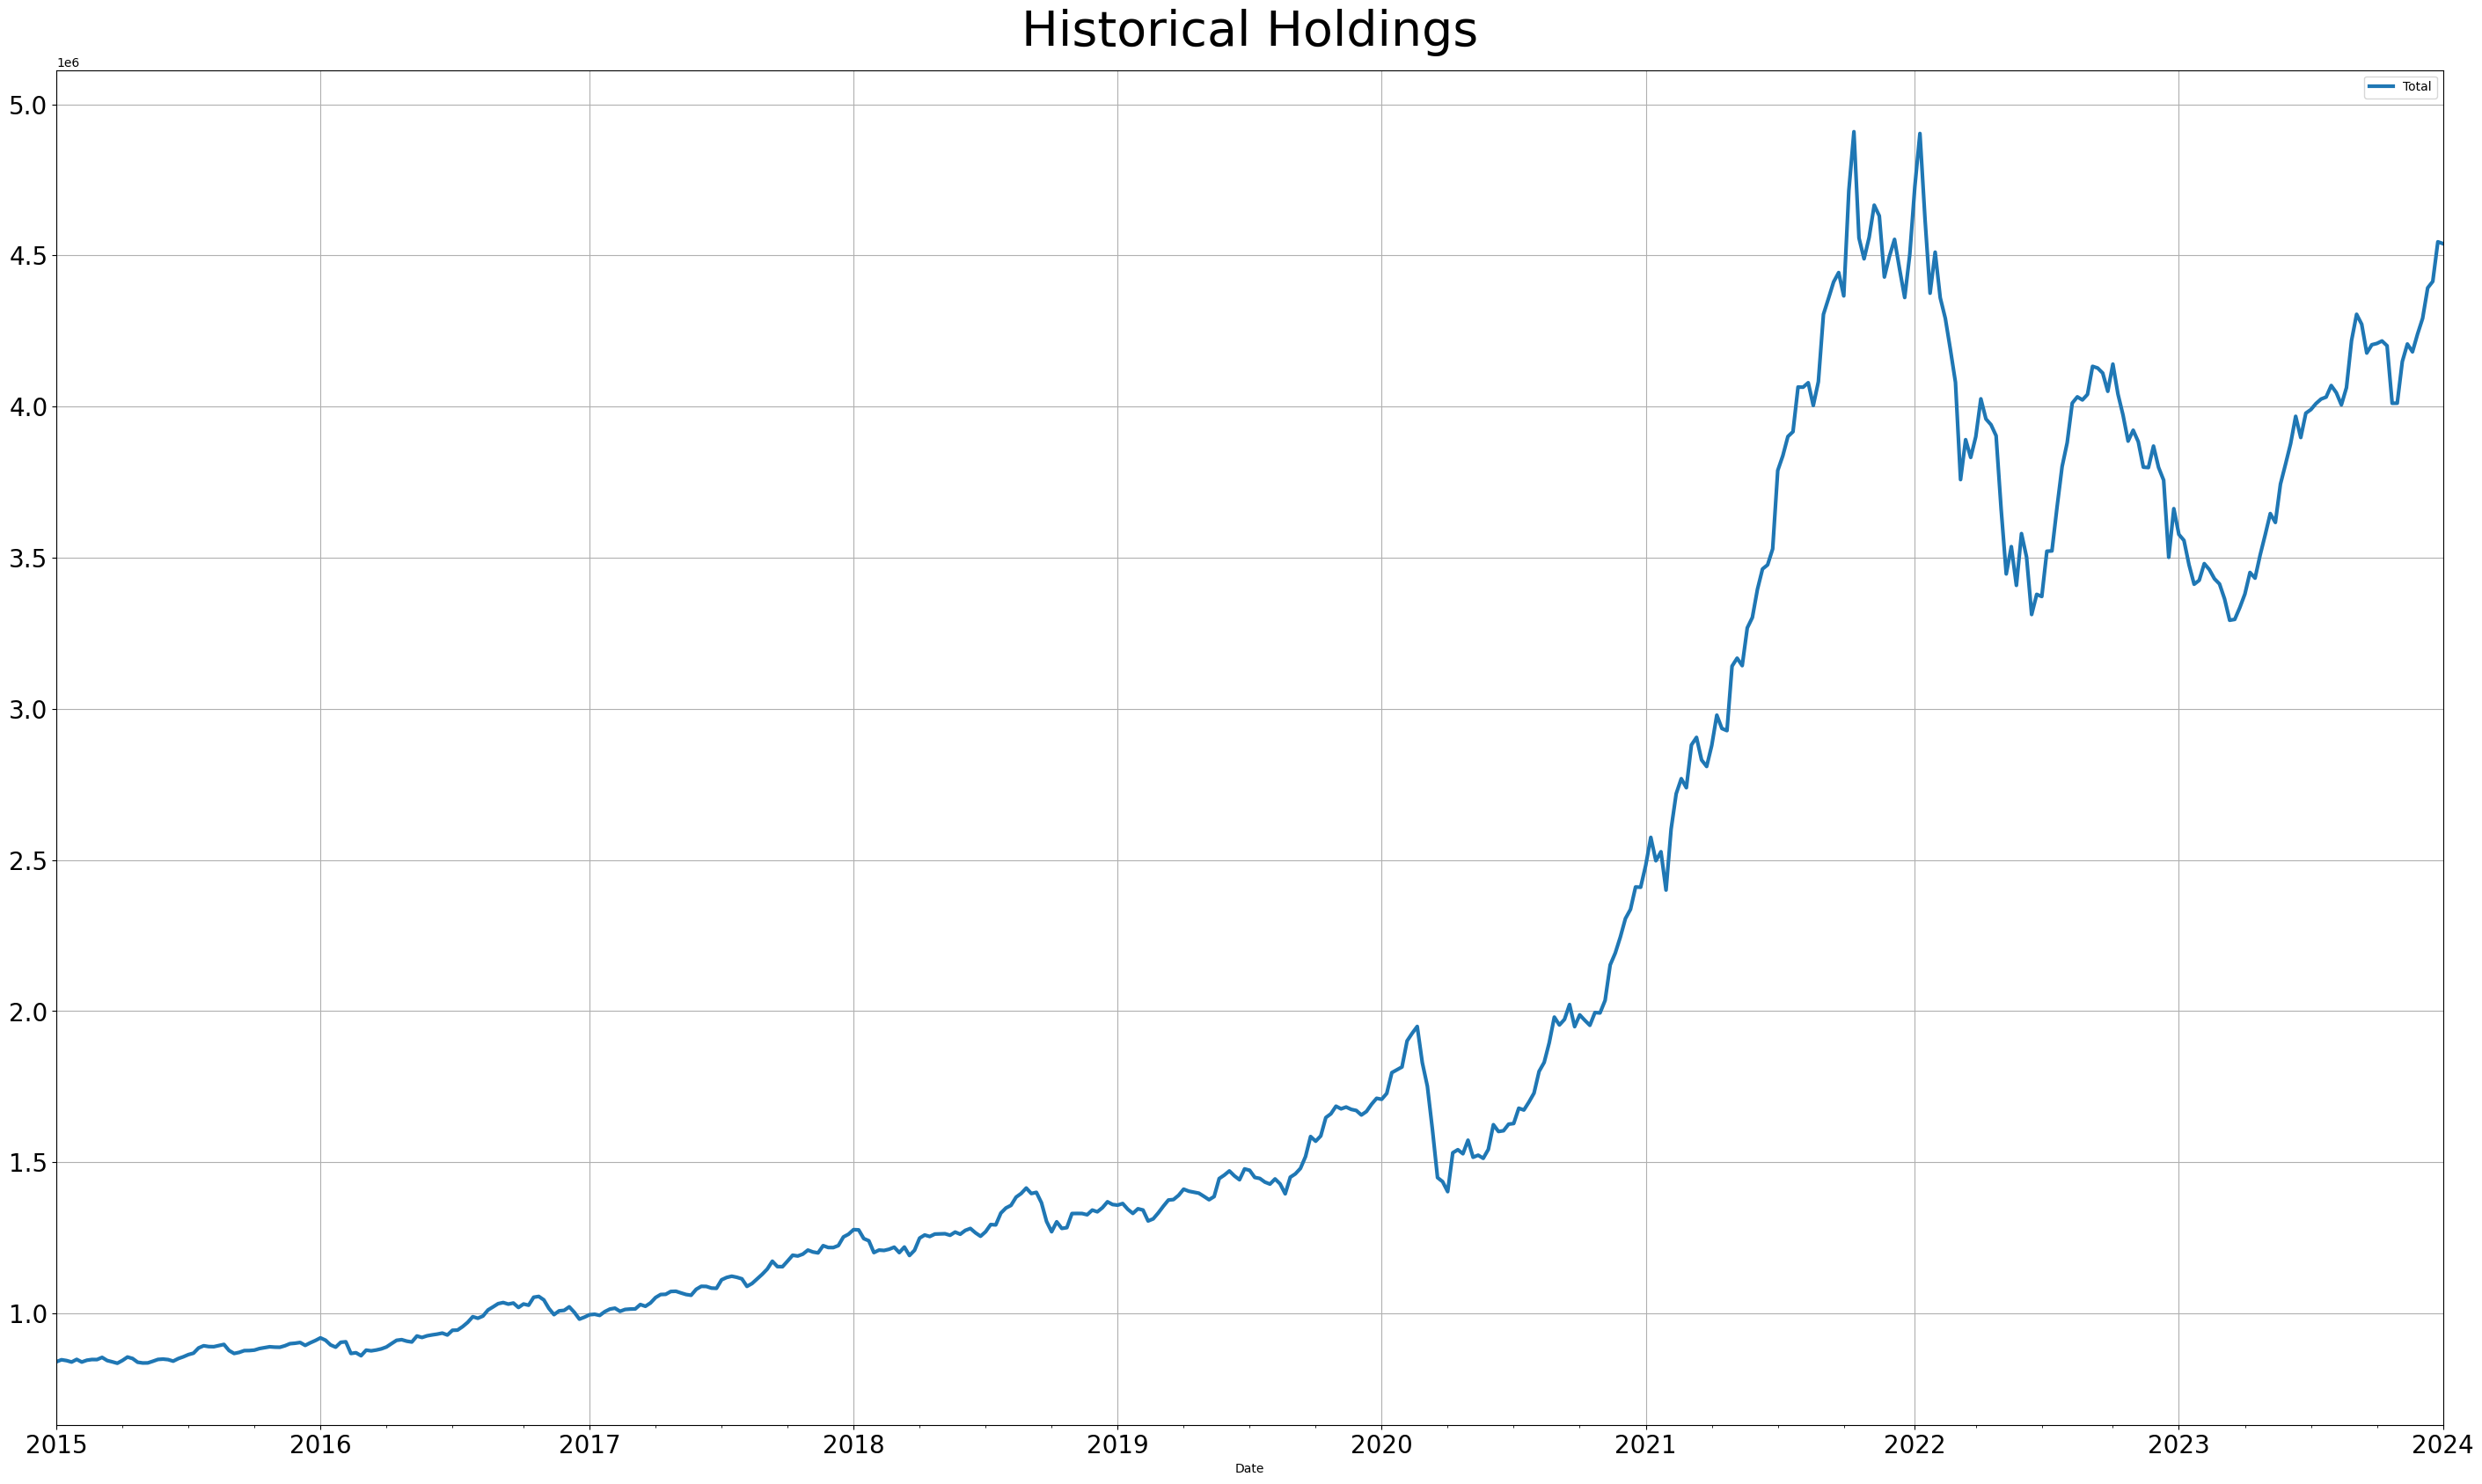

In [41]:
dir(fig_total)
# fig_total.figure.suptitle('Holdings Historically', fontsize=30)

# fig_total
fig_total.get_title()
(fig_total)

['ArtistList',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_deprecate_noninstance',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_

# spy['Close'].values, spy['Close'].index.values
spy.describe()
# dir(spy)
# spy.to_dict()
# spy['Adj Close']

In [5]:
def get_first_non_nan(df):
    df1 = df.fillna('NULL')
    d = dict()
    for s in NSE_BSE.keys():
        for v in df1[s].to_list():
            if v != 'NULL':
                break

        d[s] = v
        
    return pd.Series(d)

# get_first_non_nan(df)

#json.dumps(getQuotes('AAPL'), indent=2)
baj = share.Share('BAJFINANCE.BO')

d = baj.get_historical(share.PERIOD_TYPE_WEEK,
                                          3,
                                          share.FREQUENCY_TYPE_WEEK,
                                          1)

# print([datetime.fromtimestamp(x) for x in d['timestamp']])
d

In [6]:
stocks = list(NSE_BSE.values()) # ['BAJFINANCE.BO', 'DMART.NS']
start = dt.datetime(2005, 1, 1)
end = dt.datetime.today() # dt.datetime(2023, 11, 30)
# d = web.DataReader(stocks, 'yahoo', start, end)
# d = data.DataReader("BAJFINANCE.BO",'yahoo', start='2021-09-10', end='2022-10-09')

yfin.pdr_override()

df = pdr.get_data_yahoo(stocks, start=start, end=end, interval='1wk') #['Adj Close']
df = df.asfreq('W-FRI', method='pad')
df = df['Adj Close']
df = df.rename(columns=BSE_NSE)



df['HAPPSTMNDS'].loc[~df.isnull().sum(1).astype(bool)].iloc[0]
df['HAPPSTMNDS']

[*********************100%%**********************]  25 of 25 completed


Date
2005-01-07           NaN
2005-01-14           NaN
2005-01-21           NaN
2005-01-28           NaN
2005-02-04           NaN
                 ...    
2023-12-08    881.950012
2023-12-15    934.700012
2023-12-22    915.500000
2023-12-29    895.799988
2024-01-05    903.549988
Freq: W-FRI, Name: HAPPSTMNDS, Length: 992, dtype: float64

In [70]:
import glob, os
files = glob.glob(f"{OUT_DIR}{PNG_FOLDER_NAME}*.png")

files.sort(key=os.path.getctime)
files

['/Users/aniron/Documents/Tracked/PyHelloWorld/docs/outputs/fundamental_data/Return on Equity.png',
 '/Users/aniron/Documents/Tracked/PyHelloWorld/docs/outputs/fundamental_data/Compounded Profit Growth.png',
 '/Users/aniron/Documents/Tracked/PyHelloWorld/docs/outputs/fundamental_data/Compounded Sales Growth.png',
 '/Users/aniron/Documents/Tracked/PyHelloWorld/docs/outputs/fundamental_data/NetProfit.png',
 '/Users/aniron/Documents/Tracked/PyHelloWorld/docs/outputs/fundamental_data/NetProfitQtr.png',
 '/Users/aniron/Documents/Tracked/PyHelloWorld/docs/outputs/fundamental_data/Sales.png',
 '/Users/aniron/Documents/Tracked/PyHelloWorld/docs/outputs/fundamental_data/SalesQtr.png',
 '/Users/aniron/Documents/Tracked/PyHelloWorld/docs/outputs/fundamental_data/EPSinRs.png',
 '/Users/aniron/Documents/Tracked/PyHelloWorld/docs/outputs/fundamental_data/EPSinRsQtr.png',
 '/Users/aniron/Documents/Tracked/PyHelloWorld/docs/outputs/fundamental_data/BAJFINANCE.png',
 '/Users/aniron/Documents/Tracked/Py

In [71]:
from os import listdir
from os.path import isfile, join

mypath = f"{OUT_DIR}{PNG_FOLDER_NAME}"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['RAJRATAN.png',
 'DMART.png',
 'DIXON.png',
 'GARFIBRES.png',
 'AFFLE.png',
 'NetProfitQtr.png',
 'Sales.png',
 'index.html',
 '.DS_Store',
 'BAJFINANCE.png',
 'DIVISLAB.png',
 'Compounded Profit Growth.png',
 'HAPPSTMNDS.png',
 'SalesQtr.png',
 'FINEORG.png',
 'BERGEPAINT.png',
 'KPITTECH.png',
 'MOLDTKPAC.png',
 'historical_portfolio_value.png',
 'Return on Equity.png',
 'holding_charts.png',
 'POLYCAB.png',
 'TATACHEM.png',
 'Compounded Sales Growth.png',
 'IONEXCHANG.png',
 'NetProfit.png',
 'RBA.png',
 'NAUKRI.png',
 'BEL.png',
 'DEVYANI.png',
 'EPSinRs.png',
 'PRINCEPIPE.png',
 'DEEPAKNTR.png',
 'LAURUSLABS.png',
 'RELAXO.png',
 'SONACOMS.png',
 'EPSinRsQtr.png',
 'PRAJIND.png']